# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
num_rows = len(df.index)
print(num_rows)

294478


c. The number of unique users in the dataset.

In [4]:
num_unq_users = len(np.unique(df["user_id"]))
print(num_unq_users)

290584


d. The proportion of users converted.

In [5]:
(df["converted"] == 1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
num_unmatches = ((df["group"] == "treatment") != 
                 (df["landing_page"] == "new_page")).sum()
print(num_unmatches)

3893


f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now create a new dataset by handling these rows properly. Store your new dataframe in **df2**.

In [9]:
df2 = df[((df["group"] == "treatment") == (df["landing_page"] == "new_page")) & 
         ((df["group"] == "control") == (df["landing_page"] == "old_page"))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to answer the following questions.

a. How many unique **user_id**s are in **df2**?

In [11]:
num_unq_user_ids = len(np.unique(df2["user_id"]))
print(num_unq_user_ids)

290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
rep_user_id = df2["user_id"][df2["user_id"].duplicated() == True].values[0]
print(rep_user_id)

773192


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2["user_id"] == rep_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop(2893)
df2[df2["user_id"] == rep_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** to answer the following questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
cvtn_rate = (df2["converted"] == 1).mean()
print(cvtn_rate)

0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
ctrl_grp = df2[df2["group"] == "control"]
ctrl_cvtn_rate = (ctrl_grp["converted"] == 1).mean()
print(ctrl_cvtn_rate)

0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
trmt_grp = df2[df2["group"] == "treatment"]
trmt_cvtn_rate = (trmt_grp["converted"] == 1).mean()
print(trmt_cvtn_rate)

0.11880806551510564


d. What is the probability that an individual received the new page?

In [18]:
new_page_prob = (df2["landing_page"] == "new_page").mean()
print(new_page_prob)

0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**I think there is no sufficient evidence to conclude that the new treatment page leads to more conversions, but it is not because of the higher conditional probability of conversions given that an individual was in the control group than the conditional probability of conversions given that an individual was in the treatment group. After all, the difference between these conditional probabilities can be due to chance; that is, their conditional probabilities could have been different if we were able to draw another sample from the population. In order to deal with this problem of randomness, we need to utilize sampling distribution and conduct a hypothesis testing to decide whether the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null: The converted rate for the new page is less than or equal to the converted rate for the old page.**

**Alternative: The converted rate for the new page is greater than the converted rate for the old page.**

$H_{0}: p_{new} \leq p_{old}$

$H_{1}: p_{new} > p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new_null = (df2["converted"] == 1).mean()
print(p_new_null)

0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old_null = (df2["converted"] == 1).mean()
print(p_old_null)

0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = len(trmt_grp.index)
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = len(ctrl_grp.index)
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice(2, n_new, 
                     p=[(1 - p_new_null), p_new_null])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice(2, n_old, 
                     p=[(1 - p_old_null), p_old_null])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
print(p_diff)

-0.001984304994350164


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(2, n_new, 
                     p=[(1 - p_new_null), p_new_null])
    old_page_converted = np.random.choice(2, n_old, 
                     p=[(1 - p_old_null), p_old_null])
    p_diffs.append(
        new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

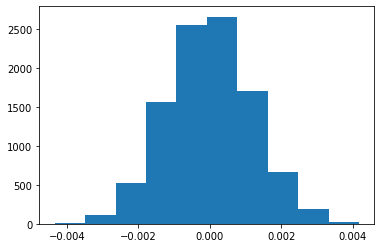

In [27]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = trmt_cvtn_rate - ctrl_cvtn_rate
p_val = (p_diffs > obs_diff).mean()
print(p_val)

0.9078


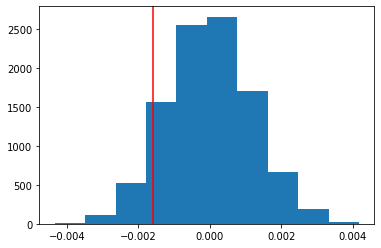

In [29]:
plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = "red")
plt.show()

k. Please explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value I just computed in part j is called the p-value in scientific studies, where it is defined as the probability of observing a statistic or one more extreme in favor of the alternative hypothesis if the null hypothesis is true. That is, assuming that the null is true, or that the difference between new and old pages in terms of conversion rates is equal to or less than zero, the magnitude of this p-value indicates how probable there is to appear positive difference between new and old pages given that the null is true. In this case, since the p-value, which is around 0.9, is larger than the type I error threshold ($\alpha$), 0.05, we fail to reject the null; in other words, we can conclude that difference in conversion rates between new and old pages is equal to or less than zero.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = (ctrl_grp["converted"] == 1).sum()
convert_new = (trmt_grp["converted"] == 1).sum()
n_old = len(ctrl_grp.index)
n_new = len(trmt_grp.index)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [31]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative = "smaller")
print(stat, pval)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score, or the standard score, is the signed fractional number of standard deviations by which the observed value is above the mean; in this particular case, the observed value is the difference in the conversion rates between new and old pages, whereas the mean is zero as it is assumed that there is no difference in the conversion rates between the old and new pages under the null hypothesis. The value of the z-score indicates that the observed value is apart from the mean, 0, by only 1.31 standard deviation, which means that the difference in the convertion rates is not far from the center of zero in the null distribution.**

**On the other hand, the p-value is the probability of observing a statistic or one more extreme in favor of the alternative hypothesis if the null hypothesis is true; in this particular case, the observed statistic is also the difference in the conversion rates between new and old pages. The p-value of 0.9 indicates that it is still likely for such a difference to appear even if the null hypothesis is true, which means that the observed difference in conversion rates is still possible under the null hypothesis, given our type I error threshold as 0.05.**

**They agree with the findings in parts j and k, in which we fail to reject the null hypothesis.  On the one hand, the z-score tells us that the observed difference is not far from zero difference; on the other, the p-value tells us that such a difference is possible even if the null hypothesis is true. In other words, they are consistent with our conclusion: the difference in conversion rates between new and old pages is equal to or less than zero.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**As the response variable we are going to predict is binary, i.e. either a conversion or no conversion indicated by 1 and 0, I should be performing a logistic regression in this case, because this is a classification problem of predicting either one of the two outcomes: a conversion or no conversion.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2["intercept"] = 1
df2["ab_page"] = pd.get_dummies(df2["group"])["treatment"]
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
logit_model = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        23:54:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**The p-value associated with ab_page is 0.19, and the reason why it differs from the value I found in part II is the difference between what were tested here and in part II.**

**In part II, the null hypothesis is that the conversion rate for new pages is the same as that for old pages, or that there is no difference in conversion rates between new and old pages; whereas the alternative hypothesis is that the conversion rate for new pages is different from that for old pages, or that there is a difference in conversion rates between new and old pages. These hypotheses can be expressed by the following notations:**

**$H_{0}: p_{new} = p_{old}$**

**$H_{1}: p_{new} \ne p_{old}$**

**where $p_{new}$ and $p_{old}$ denote the conversion rates for new and old pages respectively. Alternatively, they can be reformulated as follows:**

**$H_{0}: p_{new} - p_{old} = 0$**

**$H_{1}: p_{new} - p_{old} \ne 0$**

**In a nutshell, the hypothesis testing in part II tested whether there is any statistically significant difference in conversion rates between people who receive new pages and those who receive old pages.**

**The null hypothesis here, however, is that there is no linear relationship between the explanatory variable, ab_page, and the response variable, the probability of being converted; or to put it in terms of a scatter plot between the explanatory variable and the response, it suggests that the population slope is equal to zero. On the other hand, the alternative is that there is a linear relationship between the explanatory variable and the response, or that the population slope is different from zero in terms of a scatter plot between the explanatory variable and the response. In other words, the hypothesis testing here tested whether there is a statistically significant linear relationship between a given explanatory variable and the response, or to be precise, whether the given explanatory attached to the coefficient given by the model has a statistically significant linear relationship with the response.**

**In conclusion, what is tested here is whether there is a linear relationship between the ab_page and the probability of being converted, which is different from testing whether there is a difference in conversion rates between new and old pages, and thus the difference in the p-values.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**I think it would be a good idea to consider other factors to add into my regression model, since the explained variance in the response by the model can be further improved and the predictions can be more accurate by adding some relevant factors. However, adding additional terms into my regression model can lead to the problem of overfitting, which means that the model captures not only the real patterns but also the random patterns specific to the data set that is used for fitting (or training) the model where its predictive performance on new data sets would be negatively impacted. Furthermore, it can complicate the model in such a way that it becomes difficult for us to interpret the output model; for example, it would be difficult for us to interpret the coefficients of a given explanatory variable if we use the quadratic, cubic or even higher order terms of it.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [35]:
countries = pd.read_csv("countries.csv")
df3 = df2.join(countries.set_index("user_id"), on = "user_id")
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [36]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


In [37]:
df3[np.unique(df3["country"])] = pd.get_dummies(df3["country"])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [38]:
logit_model2 = sm.Logit(df3["converted"], df3[["intercept", "ab_page", "CA", "UK"]])
results2 = logit_model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:               2.323e-05
Time:                        23:54:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [39]:
np.exp(results2.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [40]:
1 / np.exp(results2.params)

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

**From the model output, it appears that country had no impact on conversion, which is shown by both the coefficients and the p-values for the respective levels of the country variable. The multiplicative change in the odds of being converted for both the groups in the UK and Canada is about the same likely as the baseline group in the US (the exponentiations of their coefficients are around 1), so it would not make a huge difference in the log odd between the levels of the country variable, holding other variables constant. On the other hand, the p-values for both CA and UK groups are still larger than a standard type I error threshold, 0.05; that is, it is still likely for such differences among different country groups to appear given the null hypothesis that there is no difference among them is true. In other words, we fail to reject the null - there is no difference in the linear relationship between the levels of explanatory categorical variable, country, and the response variable, the log odd of being converted.** 

h. Though you have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df3["ab_page_CA"] = df3["ab_page"] * df3["CA"]
df3["ab_page_UK"] = df3["ab_page"] * df3["UK"]
df3["ab_page_US"] = df3["ab_page"] * df3["US"]

df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_CA,ab_page_UK,ab_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [42]:
logit_model3 = sm.Logit(df3["converted"], df3[["intercept", "ab_page", "CA", "UK", 
                                               "ab_page_CA", "ab_page_UK"]])
results3 = logit_model3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        23:54:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [43]:
np.exp(results3.params)

intercept     0.137178
ab_page       0.979646
CA            0.982625
UK            0.994272
ab_page_CA    0.954198
ab_page_UK    1.031896
dtype: float64

In [44]:
1 / np.exp(results3.params)

intercept     7.289813
ab_page       1.020776
CA            1.017682
UK            1.005761
ab_page_CA    1.048001
ab_page_UK    0.969090
dtype: float64

**From the model output, it appears that the interactions between page and country had no impact on conversion. In terms of the coefficients, the multiplicative changes in the odds of being converted for the other two interaction groups of ab_page_CA and ab_page_UK is around the same likely as the baseline interaction group of ab_page_US (the exponentiations of their coefficients are around 1), so it would not make a huge difference in the log odds of being converted among the interactions between page and country. In terms of the p-values, both the interaction groups in Canada and the UK have p-values that are larger than a standard type I error threshold of 0.05, so it is still likely for such differences between these two groups and the baseline one to appear given the null hypothesis is true; that is to say, we fail to reject the null for the interaction groups in Canada and the UK - there is no difference in the slope between these groups and the baseline one, the interaction group in the US.**

**In addition, the base variables of CA and UK also have the multiplicative changes in the odds that are around the same likely as the baseline in the US, along with their p-values higher than the threshold. On the other hand, the base variable of ab_page also have the multiplicative change in the odds that is around the same likely as the baseline (those who receive old pages compared to the baseline group who receive new pages), along with its p-value higher than the threshold. In other words, there is no statistically significant difference in the slope between the country levels as well as between whether an individual receive the new or old page. Based on this findings, I would recommend the company to keep the old page.**